# Kalman filter with time-dependent matrices

In this problem, we study a modification of the Kalman filter that allows for coefficient matrices that vary over time. Critically, this variation can be either deterministic, or stochastic but independent of the shock sequences $\left\{w_{t+1}\right\}_{t=0}^\infty$, $\left\{v_{t}\right\}_{t=0}^\infty$.

We are given the state space model

\begin{equation}
\begin{array}{rclll}
x_{t+1} & = & A_{o}x_{t}+C_t w_{t+1} & \qquad n\times 1 & \qquad w_{t+1}\sim
N\left( 0,I_{p}\right)  \\
y_{t} & = & Gx_{t}+v_{t} & \qquad m\times 1 & \qquad v_{t}\sim N\left(
0,R_t\right) .%
\end{array}
\end{equation}

Here, $x_{t}$ is an unobservable state vector that follows a Gaussian Markov
process, $y_{t}$, is a measurement vector and $v_{t}$ is measurement noise
independent of $\left\{ w_{t}\right\} _{t=1}^{\infty }$. We assume an
initial condition

\begin{equation}
x_{0}\sim N\left( \hat{x}_{0},\Sigma _{0}\right) \text{.}
\end{equation}

The difference relative to the standard Kalman (1960) filtering algorithm is that now, $C_t$ and $R_t$ are indexed by $t$. We assume that these matrices are known at time $t$, otherwise would need to take appropriate expectations.

This modification has a trivial impact on the filtering equations. The Kalman (1960) filtering algorithm still leads to a recursive formula for
the best predictor of $x_{t}$ given observations $y^{t-1}=\left(
y_{t-1},\ldots ,y_{0}\right) $. The system continues to have a linear-Gaussian structure conditional on the matrices $C_t$, $R_t$, so we can infer that the predictor will also be Gaussian. It is therefore again sufficient to construct predictors for the first two moments of its
distribution

\begin{align}
\hat{x}_{t} &=E\left[ x_{t}\mid y^{t-1}\right] \\
\Sigma _{t} &=E\left[ \left( x_{t}-\hat{x}_{t}\right) \left( x_{t}-\hat{x}%
_{t}\right) ^{\prime }\right] .  
\end{align}

The only difference is that now, the innovations representation involves $C_t$ and $R_t$:

\begin{align}
a_{t} &=y_{t}-G\hat{x}_{t} \\
K_{t} &=A_{o}\Sigma _{t}G^{\prime }\left( G\Sigma _{t}G^{\prime }+R_t\right)
^{-1} \\
\hat{x}_{t+1} &=A_{o}\hat{x}_{t}+K_{t}a_{t}  \\
\Sigma _{t+1} &=\left( A_{o}-K_{t}G\right) \Sigma _{t}\left(
A_{o}-K_{t}G\right) ^{\prime }+C_t C_t^{\prime }+K_{t}R_tK_{t}^{\prime } 
\end{align}

and, for a sequence of data $y_t$, $t = 0,1,\ldots,T-1$, yields the path $\hat{x}_t$, $\Sigma_t$, $t=1,\ldots,T$.

## Volatility of shocks that depends on the recession state

We now apply the Kalman filter model to the following problem. Let $x_t$ represents the productivity of the economy that follows a scalar AR(1) process:

\begin{equation}
x_{t+1} = A_o x_t + C_t w_{t+1}.
\end{equation}

We do not observe productivity but we do measure GDP, which represents a noisy measurement of the true underlying productivity

\begin{equation}
y_t = G x_t + v_t \qquad v_t \sim N(0,R_t)
\end{equation}

We want to construct the best estimate $\hat{x}_t$ and the associated variance of the estimate $\Sigma_t$ for the underlying productivity.

We assume that the matrices $C_t$ and $R_t differ in expansions and recessions. In particular, define the dummy variable $r_t$ to be $r_t = 1$ if the economy is in a recession in period $t$, and $r_t = 0$ otherwise. We collect the recession data from the <a href="https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions">NBER webpage on recession dating</a>.

Then we set $C_t = C^r$ when $r_t = 1$ (recession), and $C_t = C^e$ when $r_t = 0$ (expansion). Similarly for $R_t = R^r$ when $r_t = 1$ and $R_t = R^e$ when $r_1 = 0$.



## Implementation

Define the local folder where graphs will be stored, and from which data will be retrieved. If you are running the notebook within Google Colab, use the second option.

In [1]:
graphfolder = "graphs/"
datafolder = "data/"

# options for Google Colab (uncomment the following lines)
# graphfolder = "gdrive/MyDrive/graphs/"
# datafolder = "gdrive/MyDrive/data/"

Import relevant packages.

In [2]:
# render graphs within notebook
%matplotlib inline

# import packages
import numpy as np

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


We first write a function that takes as input the model parameters, the prior parameters, and data $y_t$, $t=0,1,\ldots,T-1$ and produces the filtered path $\hat{x}_t$ and variance $\Sigma_t$, $t=1,\ldots,T$. Part of the <tt>model</tt> variable is also a complete description of the sequence of matrices $C_t$ and $R_t$.

In [3]:
def Kalman_filter(model,y):
    # model: model parameters in matrix form
    # data: m x T matrix of data, one vector of observations in each column
    if model["Ao"].ndim < 3:
        Ao = model["Ao"]
    if model["C"].ndim < 3:
        C = model["C"]
    if model["G"].ndim < 3:
        G = model["G"]
    if model["R"].ndim < 3:
        R = model["R"]
    m,T,n,p = y.shape[0], y.shape[1], model["C"].shape[0], model["C"].shape[1]
    
    xhat, Sigmahat = np.empty([n,T+1]), np.empty([n,n,T+1])
    xhat[:,0] = model["x0hat"]
    Sigmahat[:,:,0] = model["Sigma0hat"]
    
    for t in range(T):
        if model["Ao"].ndim == 3:
            Ao = model["Ao"][:,:,t]
        if model["C"].ndim == 3:    
            C = model["C"][:,:,t]
        if model["G"].ndim == 3:    
            G = model["G"][:,:,t]
        if model["R"].ndim == 3:
            R = model["R"][:,:,t]

        a = y[:,t] - G @ xhat[:,t]
        K = Ao @ Sigmahat[:,:,t] @ G.transpose() @ np.linalg.inv(G @ Sigmahat[:,:,t] @ G.transpose() + R)
        xhat[:,t+1] = Ao @ xhat[:,t] + K @ a
        Sigmahat[:,:,t+1] = (Ao-K@G)@Sigmahat[:,:,t]@(Ao-K@G).transpose()  + C@C.transpose() + K@R@K.transpose()
    
    return xhat, Sigmahat

Load GDP data from FRED.

In [4]:
# myLoadDataFRED uses the pandas_reader.data.Reader function to download time series from FRED
data_Y = ec.LoadDataFRED(series=['GDPC1'],transform='none')

# cosntruct GDP growth rate
data = 4*np.reshape(np.log(data_Y['GDPC1'][1:]) - np.log(data_Y['GDPC1'][:-1]), (1,-1))
data = data - data.mean()
data_year = np.reshape(data_Y["year"][1:], (1,-1))

# initial and last quarter of the data
Tbegin = data_Y["orig"].index[1].year*10 + data_Y["orig"].index[1].quarter
Tend = data_Y["orig"].index[-1].year*10 + data_Y["orig"].index[-1].quarter

In [5]:
# create a vector of recession dummies using a pre-defined function CreateRecessionDummies, with data downloaded from the NBER website
Tint = [Tbegin,Tend]
rec_dates,rec_dummies = ec.CreateRecessionDummies(Tint)
T = len(rec_dates)

Run alternative models.

In [6]:
# common model parameters
model = {}
model["Ao"],model["G"] = np.array([[0.98]]),np.array([[1]])
model["x0hat"],model["Sigma0hat"] = 0, 0.1**2
Ce, Cr, Re, Rr = 0.02, 0.04, 0.05**2, 0.1**2

# bechmark parameters (constant C and R)
model["C"] = np.array([[Ce]])
model["R"] = np.array([[Re]])

# run the benchmark model
xhat,Sigmahat = Kalman_filter(model,data)

# time-varying C parameter
model_Ct = model.copy()
model_Ct["C"] = np.reshape(rec_dummies*Cr + (1-rec_dummies)*Ce,(1,1,-1))
xhat_Ct,Sigmahat_Ct = Kalman_filter(model_Ct,data)

# time-varying C parameter
model_Rt = model.copy()
model_Rt["R"] = np.reshape(rec_dummies*Rr + (1-rec_dummies)*Re,(1,1,-1))
xhat_Rt,Sigmahat_Rt = Kalman_filter(model_Rt,data)

Plot data and the resulting estimated paths $x_t$ for alternative model specifications.

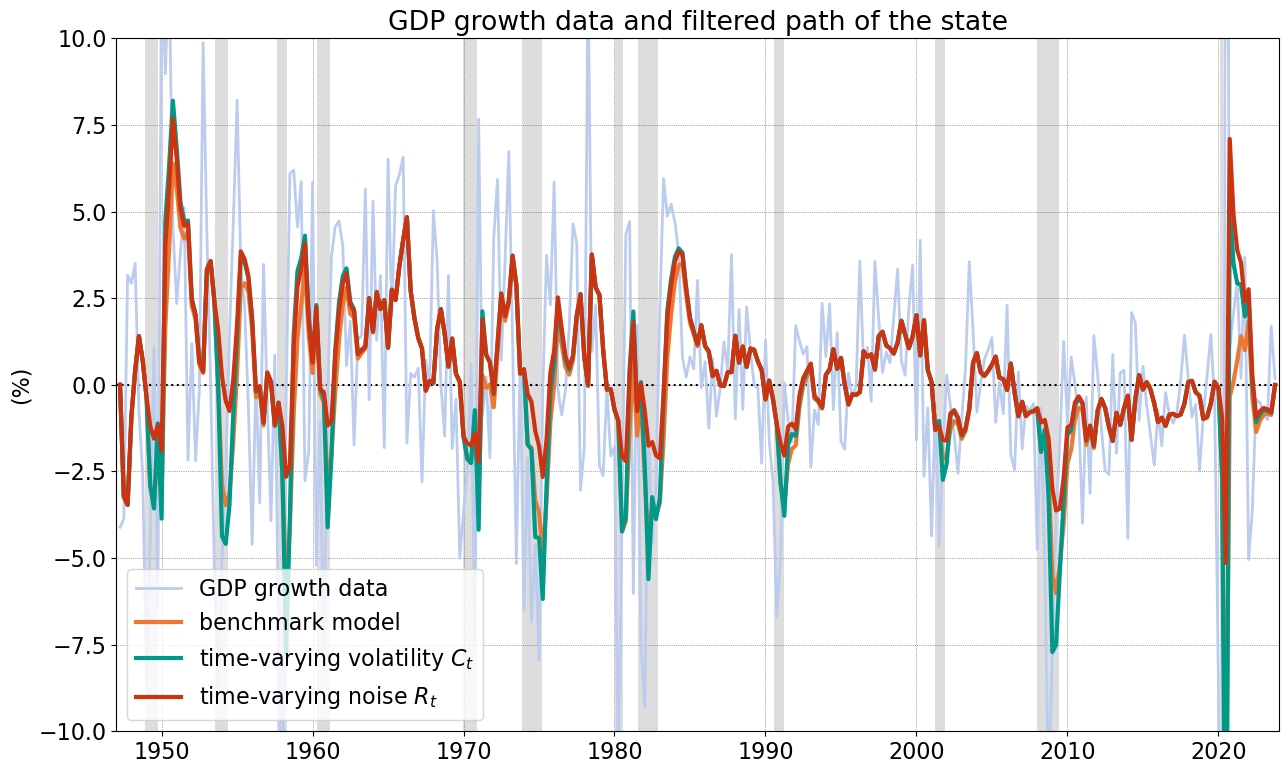

In [7]:
fig_param = {'figsize' : [15,9], 'fontsize': 16, 'subplots': [1,1],
         'title': 'GDP growth data and filtered path of the state',
         'xlim': [1947,2024], 'ylim': [-10,10],
         'xlabel': '', 'ylabel': '(%)',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': True,
         'showNBERrecessions' : True, 'showNBERrecessions_y': [-30,30]}
    
fig,ax = ec.GenerateTSPlot(fig_param)

ax.plot(data_year.transpose(),data[0:1,:].transpose()*100,
            linewidth=2,color=ec.tolColor['tolPaleBlue'],label='GDP growth data')
ax.plot(data_year.transpose(),xhat[:,:-1].transpose()*100,
            linewidth=3,color=ec.tolColor['tolVibrantOrange'],label='benchmark model')
ax.plot(data_year.transpose(),xhat_Ct[:,:-1].transpose()*100,
            linewidth=3,color=ec.tolColor['tolVibrantTeal'],label='time-varying volatility $C_t$')
ax.plot(data_year.transpose(),xhat_Rt[:,:-1].transpose()*100,
            linewidth=3,color=ec.tolColor['tolVibrantRed'],label='time-varying noise $R_t$')

x = ax.legend(loc="lower left")

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + '/filtering_recessions_gdp_path.pdf',bbox_inches='tight')

Zoom on a subperiod.

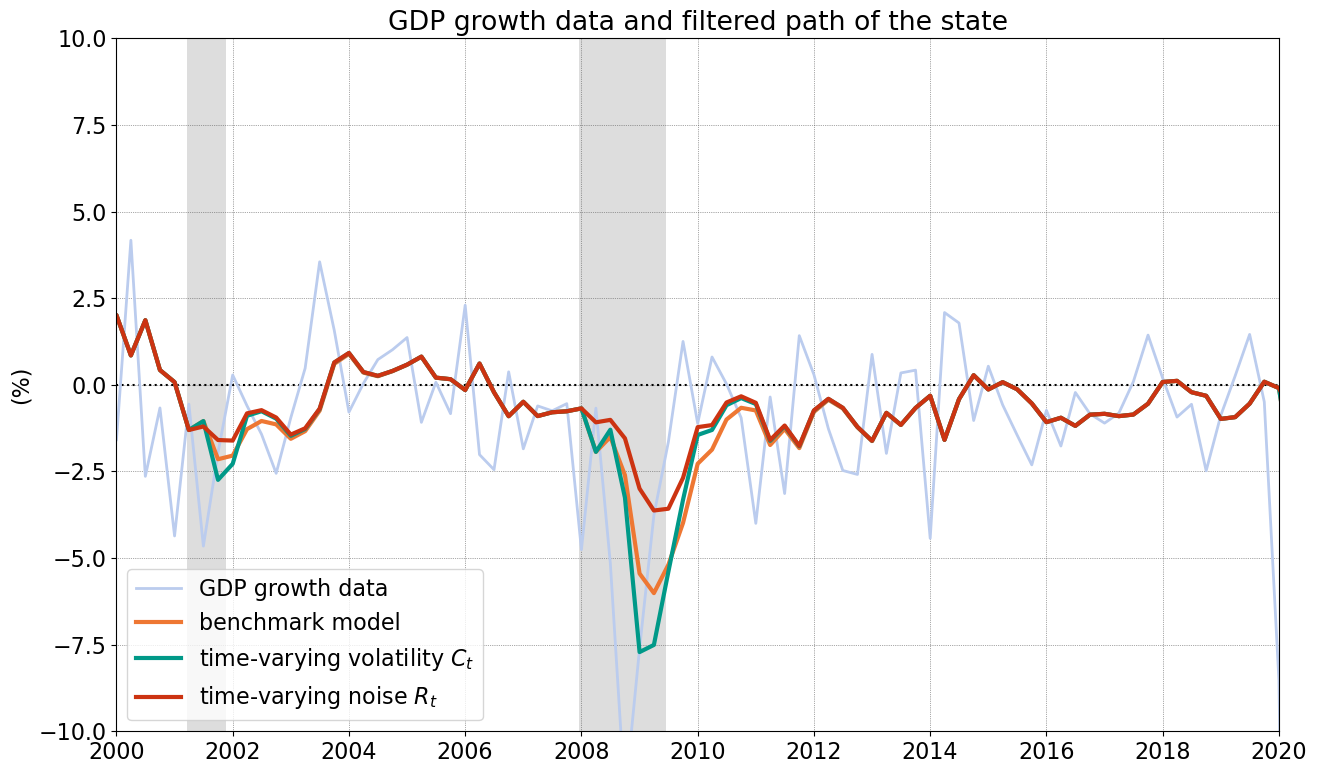

In [8]:
fig_param = {'figsize' : [15,9], 'fontsize': 16, 'subplots': [1,1],
         'title': 'GDP growth data and filtered path of the state',
         'xlim': [2000,2020], 'ylim': [-10,10],
         'xlabel': '', 'ylabel': '(%)',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': True,
         'showNBERrecessions' : True, 'showNBERrecessions_y': [-30,30]}
    
fig,ax = ec.GenerateTSPlot(fig_param)

ax.plot(data_year.transpose(),data[0:1,:].transpose()*100,
            linewidth=2,color=ec.tolColor['tolPaleBlue'],label='GDP growth data')
ax.plot(data_year.transpose(),xhat[:,:-1].transpose()*100,
            linewidth=3,color=ec.tolColor['tolVibrantOrange'],label='benchmark model')
ax.plot(data_year.transpose(),xhat_Ct[:,:-1].transpose()*100,
            linewidth=3,color=ec.tolColor['tolVibrantTeal'],label='time-varying volatility $C_t$')
ax.plot(data_year.transpose(),xhat_Rt[:,:-1].transpose()*100,
            linewidth=3,color=ec.tolColor['tolVibrantRed'],label='time-varying noise $R_t$')

ax.set_xticks(np.arange(2000,2021,2))
x = ax.legend(loc="lower left")

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + '/filtering_recessions_gdp_path_zoomed.pdf',bbox_inches='tight')

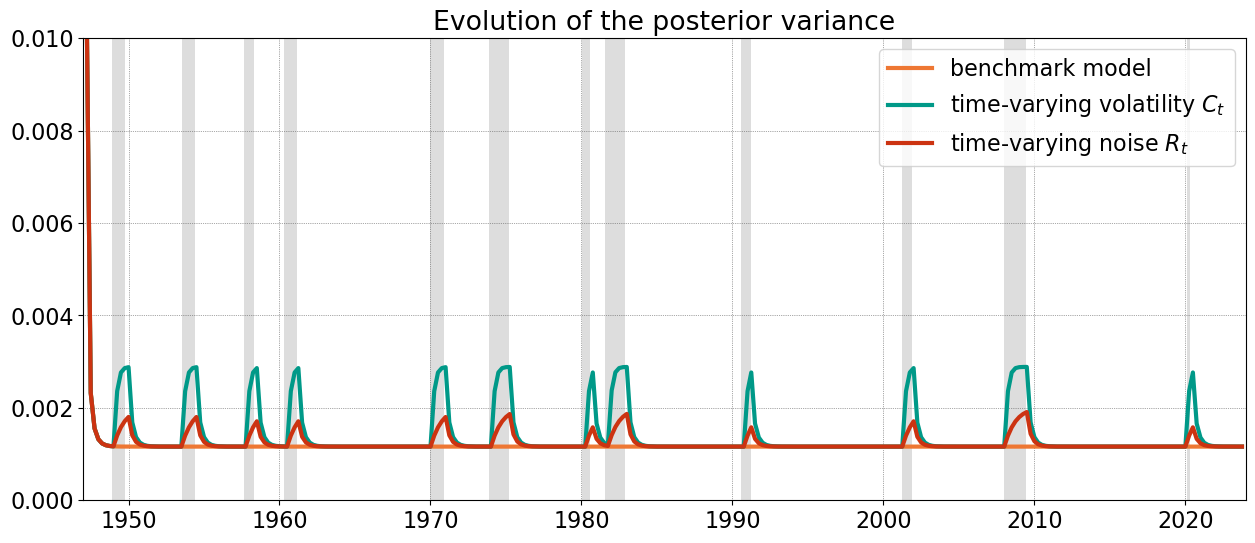

In [9]:
fig_param = {'figsize' : [15,6], 'fontsize': 16, 'subplots': [1,1],
         'title': 'Evolution of the posterior variance',
         'xlim': [1947,2024], 'ylim': [0,0.01],
         'xlabel': '', 'ylabel': '',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : True, 'showNBERrecessions_y': [-30,30]}
    
fig,ax = ec.GenerateTSPlot(fig_param)

ax.plot(data_year.transpose(),np.squeeze(Sigmahat[:,:,:-1]),
            linewidth=3,color=ec.tolColor['tolVibrantOrange'],label='benchmark model')
ax.plot(data_year.transpose(),np.squeeze(Sigmahat_Ct[:,:,:-1]),
            linewidth=3,color=ec.tolColor['tolVibrantTeal'],label='time-varying volatility $C_t$')
ax.plot(data_year.transpose(),np.squeeze(Sigmahat_Rt[:,:,:-1]),
            linewidth=3,color=ec.tolColor['tolVibrantRed'],label='time-varying noise $R_t$')

x = ax.legend(loc="upper right")

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + '/filtering_recessions_gdp_variance.pdf',bbox_inches='tight')